# Random Forest Classifier

RF classifer used to classify protein coding genes in procaryotic DNA sequences. 

- Hyperparamter tuning
- Selecting best model
- Accuracy of all genomes
- Feature importance
- Training curves

In [1]:
# Importing data
import pandas as pd
import time

# Preprocessing and encoding variables
import numpy as np
from sklearn import preprocessing

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Visualising feature importance and making plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
import pydot

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
G1 = pd.read_csv('../input/genomes-part1/G1.features.csv')

In [3]:
G = G1
G.tail(5)

,Unnamed: 0,Type,Length,Dataset,Genome,GC_content,GC1_content,GC2_content,GC3_content,Start_ATG,...,c_weight_TCG,c_weight_TCT,c_weight_TGA,c_weight_TGC,c_weight_TGG,c_weight_TGT,c_weight_TTA,c_weight_TTC,c_weight_TTG,c_weight_TTT
8644,8645,CDS,4563,1,Mycobacterium tuberculosis,0.520272,0.552268,0.420118,0.588429,1,...,0.203540,0.123894,0.0,0.266667,1,0.733333,0.043478,0.517241,0.069565,0.482759
8645,8646,CDS,4581,1,Mycobacterium tuberculosis,0.492032,0.527177,0.471513,0.477407,1,...,0.093023,0.131783,1.0,0.333333,1,0.666667,0.182796,0.480000,0.129032,0.520000
8646,8647,CDS,4617,1,Mycobacterium tuberculosis,0.568984,0.671215,0.476933,0.558804,1,...,0.228571,0.133333,0.0,0.428571,1,0.571429,0.129730,0.333333,0.124324,0.666667
8647,8648,CDS,4962,1,Mycobacterium tuberculosis,0.529625,0.622733,0.414148,0.551995,1,...,0.138889,0.101852,0.0,0.666667,1,0.333333,0.145000,0.533333,0.145000,0.466667
8648,8649,CDS,7077,1,Mycobacterium tuberculosis,0.499929,0.531581,0.459941,0.508266,1,...,0.139013,0.107623,1.0,0.400000,1,0.600000,0.142857,0.450704,0.095238,0.549296


In [4]:
G = G1.iloc[: , 1:]
G.tail(5)

,Type,Length,Dataset,Genome,GC_content,GC1_content,GC2_content,GC3_content,Start_ATG,Start_GTG,...,c_weight_TCG,c_weight_TCT,c_weight_TGA,c_weight_TGC,c_weight_TGG,c_weight_TGT,c_weight_TTA,c_weight_TTC,c_weight_TTG,c_weight_TTT
8644,CDS,4563,1,Mycobacterium tuberculosis,0.520272,0.552268,0.420118,0.588429,1,0,...,0.203540,0.123894,0.0,0.266667,1,0.733333,0.043478,0.517241,0.069565,0.482759
8645,CDS,4581,1,Mycobacterium tuberculosis,0.492032,0.527177,0.471513,0.477407,1,0,...,0.093023,0.131783,1.0,0.333333,1,0.666667,0.182796,0.480000,0.129032,0.520000
8646,CDS,4617,1,Mycobacterium tuberculosis,0.568984,0.671215,0.476933,0.558804,1,0,...,0.228571,0.133333,0.0,0.428571,1,0.571429,0.129730,0.333333,0.124324,0.666667
8647,CDS,4962,1,Mycobacterium tuberculosis,0.529625,0.622733,0.414148,0.551995,1,0,...,0.138889,0.101852,0.0,0.666667,1,0.333333,0.145000,0.533333,0.145000,0.466667
8648,CDS,7077,1,Mycobacterium tuberculosis,0.499929,0.531581,0.459941,0.508266,1,0,...,0.139013,0.107623,1.0,0.400000,1,0.600000,0.142857,0.450704,0.095238,0.549296


In [5]:
G = G.dropna()
G.isnull().sum()

Type            0
Length          0
Dataset         0
Genome          0
GC_content      0
               ..
c_weight_TGT    0
c_weight_TTA    0
c_weight_TTC    0
c_weight_TTG    0
c_weight_TTT    0
Length: 14791, dtype: int64

In [6]:
print('The shape of our dataframe is:', G.shape)

The shape of our dataframe is: (8648, 14791)


## Encoding features

In [7]:
def encode_feature(array):
    """ Encode a categorical array into a number array
    
    :param array: array to be encoded
    :return: numerical array
    """
  
    encoder = preprocessing.LabelEncoder()
    encoder.fit(array)
    return encoder.transform(array)

In [8]:
class_names = ['CDS', 'LORF']
targets = G["Type"].values
print(targets)

['CDS' 'CDS' 'CDS' ... 'CDS' 'CDS' 'CDS']


In [9]:
targets = encode_feature(targets)
print(targets)

[0 0 0 ... 0 0 0]


## Selecting features and targets and converting data to arrays

In [10]:
# Labels are the values we want to predict
labels = targets

# Remove the labels from the features -> axis 1 refers to the columns
features = G.drop(['Type','Genome', 'Dataset'], axis = 1)

# Saving feature names as list for later use
feature_names = list(features.columns)

# Convert to numpy array
features = np.array(features)

In [11]:
print('The shape of our features are:', features.shape)

The shape of our features are: (8648, 14788)


## Split into training and testing sets

In [12]:
# Split the data into training and testing sets -> x = features and y = labels/targets
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [13]:
print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (6486, 14788)
Training Labels Shape: (6486,)
Testing Features Shape: (2162, 14788)
Testing Labels Shape: (2162,)


## Training visualizations

In [14]:
final_model = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features='auto', 
                             max_depth=20, bootstrap=False, random_state = 42)

In [15]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(estimator = final_model, param_grid = tree_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

tree_grid_search.fit(train_x, train_y);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 17.2min finished


In [16]:
def plot_results(model, param = 'n_estimators', name = 'Number of trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(15, 8))
    
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'Train')
    plt.plot(param_values, test_scores, 'go-', label = 'Test')
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel(name, fontsize=25, labelpad=20)
    plt.ylabel('Accuracy score [%]', fontsize=25, labelpad=20)
    #plt.title('Score vs %s' % name, fontsize=25)
    plt.legend(fontsize=20)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel(name, fontsize=25, labelpad=20)
    plt.ylabel('Train time [sec]', fontsize=25, labelpad=20)
    #plt.title('Train time vs %s' % name, fontsize=25)
    
    plt.savefig('tuning_num_trees.png', dpi=300, bbox_inches='tight')
    plt.tight_layout(pad = 4)

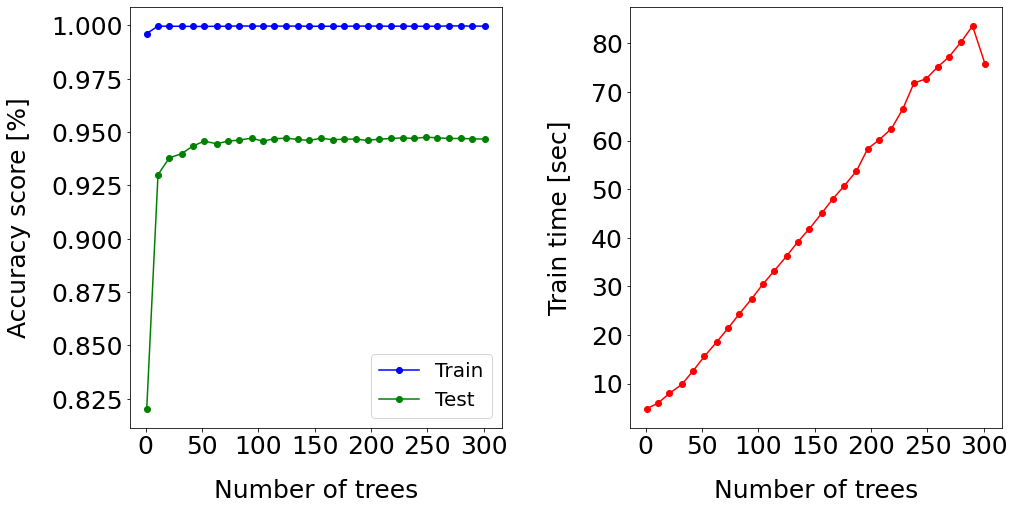

In [17]:
plot_results(tree_grid_search)